In [1]:
using IJulia, Plots
using JuliaDB, CSV, OnlineStats, StatsBase, Random, Distributions, LinearAlgebra
using Distributed
import StatsBase.predict, StatsBase.score

### Total Memory (in Mb)

In [ ]:
Sys.total_memory() / 2^20

### Free Memory (in Mb)

In [ ]:
Sys.free_memory() / 2^20

# CSV File

In [185]:
f = CSV.File("/Users/guillaume/Downloads/ml-latest-small/ratings.csv", use_mmap=false);

In [2]:
mutable struct Param
    weights::Vector{Float64}
    bias::Float64
end

User = Param
Item = Param

Param

### TODO: Utilize Matrix instead of Dict{Int64, Item}, with unrated rows removed!

In [217]:
function sgd(f::CSV.File, k::Int64=10;
        nepochs::Int64=10,
        lr::Float64=0.01,
        reg::Float64=0.0,
        cb::Union{Nothing, Function}=nothing)
    
    μ::Float64 = value(fit!(Mean(), (row.rating for row in f)))
    items::Dict{Int64, Item} = Dict{Int64, Item}()
    users::Dict{Int64, User} = Dict{Int64, User}()
    
    for epoch in 1:nepochs
        cost::Float64 = zero(Float64)
        for r in f
            i, u, rating = r.movieId, r.userId, r.rating
            
            if epoch == 1
                haskey(items, i) || (items[i] = Item(rand(MvNormal(k, 1e-4)), zero(Float64)))
                haskey(users, u) || (users[u] = User(rand(MvNormal(k, 1e-4)), zero(Float64)))
            end
            
            e::Float64 = μ + items[i].bias + users[u].bias + dot(items[i].weights, users[u].weights) - rating
            cost += abs2(e) 
            
            items[i].weights -= lr*2*(e*users[u].weights + reg*items[i].weights)
            users[u].weights -= lr*2*(e*items[i].weights + reg*users[u].weights)
            items[i].bias -= lr*2*(e + reg*items[i].bias)
            users[u].bias -= lr*2*(e + reg*users[u].bias)
        end

        if cb !== nothing
            cb(epoch, cost)
        end
    end
    
    return (items, users)
end

sgd (generic function with 2 methods)

In [ ]:
costs = []
@time items, users = sgd(f, 100;
    nepochs=10,
    lr=0.01,
    cb=(epoch, cost)->begin
        IJulia.clear_output(true)
        println("epoch: $(epoch), cost: $(cost)")
        push!(costs, cost)
        end)

plot(costs)

# Distributed Database

In [3]:
addprocs(4)
@everywhere using JuliaDB

In [ ]:
rmprocs(workers())

In [ ]:
;ls -lh /Users/guillaume/Downloads/ml-latest-small/ratings

In [ ]:
tm = Int64(Sys.total_memory()) # / 2^20

In [ ]:
let dirpath = "/Users/guillaume/Downloads/ml-latest-small/ratings"
    reduce(+, filesize(joinpath(dirpath, f)) for f in readdir(dirpath))
end

In [ ]:
filesize("/Users/guillaume/Downloads/ml-latest-small/ratings/ratings_00")

original_file_size / nchunks

nfiles_per_chunk * split_file_size * nworkers <= total_memory

In [ ]:
t = loadndsparse("/Users/guillaume/Downloads/ml-latest-small/ratings.csv";
    indexcols=["movieId", "userId"], datacols=["rating"], colnames=["userId", "movieId", "rating", "timestamp"],
    header_exists=true)
tbl = distribute(t, 100)

In [4]:
loadndsparse("/Users/guillaume/Downloads/ml-latest-small/ratings";
    indexcols=["movieId", "userId"], datacols=["rating"], colnames=["userId", "movieId", "rating", "timestamp"],
    header_exists=false, output="bin", chunks=4)
tbl = load("bin")

2-d Distributed NDSparse with 100836 values (1 field named tuples) in 4 chunks:
movieId  userId │ rating
────────────────┼───────
1        1      │ 4.0
1        5      │ 4.0
1        7      │ 4.5
1        15     │ 2.5
1        17     │ 4.5
1        18     │ 3.5
1        19     │ 4.0
1        21     │ 3.5
1        27     │ 3.0
1        31     │ 5.0
1        32     │ 3.0
1        33     │ 3.0
1        40     │ 5.0
1        43     │ 5.0
1        44     │ 3.0
1        45     │ 4.0
1        46     │ 5.0
1        50     │ 3.0
1        54     │ 3.0
1        57     │ 5.0
1        63     │ 5.0
1        64     │ 4.0
1        66     │ 4.0
1        68     │ 2.5
                ⋮

### SGD

In [ ]:
function sgd(t::JuliaDB.DNDSparse, k::Int64=10;
        nepochs::Int64=10,
        lr::Float64=0.01,
        reg::Float64=0.0,
        cb::Union{Nothing, Function}=nothing)
    
    μ::Float64 = value(reduce(Mean(), t; select = :rating))
    items::Dict{Int64, Item} = Dict{Int64, Item}()
    users::Dict{Int64, User} = Dict{Int64, User}()
    
    for epoch in 1:nepochs
        cost::Float64 = zero(Float64)
        for r in collect(rows(t))
            i, u, rating = r.movieId, r.userId, r.rating
            
            haskey(items, i) || (items[i] = Item(rand(MvNormal(k, 1e-4)), zero(Float64)))
            haskey(users, u) || (users[u] = User(rand(MvNormal(k, 1e-4)), zero(Float64)))
            
            e::Float64 = μ + items[i].bias + users[u].bias + dot(items[i].weights, users[u].weights) - rating
            cost += abs2(e) 
            
            items[i].weights -= lr*2*(e*users[u].weights + reg*items[i].weights)
            users[u].weights -= lr*2*(e*items[i].weights + reg*users[u].weights)
            items[i].bias -= lr*2*(e + reg*items[i].bias)
            users[u].bias -= lr*2*(e + reg*users[u].bias)
        end

        if cb !== nothing
            cb(epoch, cost)
        end
    end
    
    return (items, users)
end

In [ ]:
costs = []
@time items, users = sgd(tbl, 100;
    nepochs=50,
    lr=0.01,
    cb=(epoch, cost)->begin
        IJulia.clear_output(true)
        println("epoch: $(epoch), cost: $(cost)")
        push!(costs, cost)
        end)

plot(costs)

### ALS

In [ ]:
function predict(t::JuliaDB.DNDSparse, P::NextTable, Q::NextTable, item::Int64, user::Int64)
    item_row = P[item]
    user_row = Q[user]
    bi = item_row.bias
    bu = user_row.bias
    item_weights = item.row[3:end]
    user_weights = user.row[3:end]
    μ = value(reduce(Mean(), t, select=:rating))
    
    return μ + bi + bu + dot(item_weights, user_weights)
end

In [ ]:
function score(t::JuliaDB.DNDSparse, P::NextTable, Q::NextTable)
    P_schema = ML.schema(P, hints=Dict(
            :movieId => nothing))

    Q_schema = ML.schema(Q, hints=Dict(
            :userId => nothing))
    
    μ = value(reduce(Mean(), t, select=:rating))
    Pmat, Qmat = ML.featuremat(P_schema, P)', ML.featuremat(Q_schema, Q)'
    
    reduce(FTSeries(Sum(), transform=r->abs2(μ + Pmat[r.movieId,1] + Qmat[r.userId,1] + dot(Pmat[r.movieId,2:end], Qmat[r.userId,2:end]) - r.rating)), t,
    select=(:movieId, :userId, :rating))
end    

In [ ]:
reduce(FTSeries(Sum(), transform=x->begin println(x); x end), tbl, select=(:movieId, :userId, :rating))

In [181]:
function als(t::JuliaDB.DNDSparse, k::Int64=10;
        nepochs::Int64=10,
        σ::Float64=1e-4,
        λ::Float64=0.001,
        reg::Float64=0.0,
        cb::Union{Nothing, Function}=nothing)
    
    items::Dict{Int64, Item} = Dict{Int64, Item}()
    users::Dict{Int64, User} = Dict{Int64, User}()
    
    mstat, ustat, rstat = reduce(Group(Extrema(Int64), Extrema(Int64), Mean()), t, select=(:movieId, :userId, :rating)).stats
    
    μ::Float64 = value(rstat)
    ni, nu = last(value(mstat)), last(value(ustat))
    
    rated_movies = unique(sort(collect(columns(tbl, :movieId))))
    rating_users = unique(sort(collect(columns(tbl, :userId))))
    
    pinit = rand(Normal(0, σ), length(rated_movies), k)
    qinit = rand(Normal(0, σ), length(rating_users), k)
    
    #P = table(rated_movies, zeros(Float64, length(rated_movies)), (pinit[:,i] for i=1:k)...,
    #    names=[:movieId, :bias, (Symbol("f_",i) for i=1:k)...], pkey=:movieId)
    #Q = table(rating_users, zeros(Float64, length(rating_users)), (qinit[:,i] for i=1:k)...,
    #    names=[:userId, :bias, (Symbol("f_",i) for i=1:k)...], pkey=:userId)
    
    P = ndsparse((movieId=rated_movies,),
        (bias=zeros(Float64, length(rated_movies)), (Symbol("f_",i)=>pinit[:,i] for i=1:k)...))
    Q = ndsparse((userId=rating_users,),
        (bias=zeros(Float64, length(rating_users)), (Symbol("f_",i)=>qinit[:,i] for i=1:k)...))
    
    
    for epoch in 1:nepochs
        for u in rating_users
            Pjoin = join(P, collect(t[:,u]), how=:inner, lkey=:movieId, rkey=:movieId)
            Pbiased = setcol(table(Pjoin), :rating, All(:bias, :rating)=>r->r.rating - μ - r.bias)
            o = reduce(LinRegBuilder(), Pbiased, select=Between(3,3+k))
            β = coef(o, λ, y=k+1, x=1:k, bias=true)
            #qu = rows(Q)[u]
            #rows(Q)[u] = Tuple([qu.userId, β[end], (i for i in β[1:end-1])...])
            qu = Q[u]
            Q[u] = Tuple([β[end], (i for i in β[1:end-1])...])
        end
        
        for i in rated_movies
            Qjoin = join(Q, collect(t[i,:]), how=:inner, lkey=:userId, rkey=:userId)
            Qbiased = setcol(table(Qjoin), :rating, All(:bias, :rating)=>r->r.rating - μ - r.bias)
            o = reduce(LinRegBuilder(), Qbiased, select=Between(3,3+k))
            β = coef(o, λ, y=k+1, x=1:k, bias=true)
            #pi = rows(P)[i]
            #rows(P)[i] = Tuple([pi.movieId, β[end], (i for i in β[1:end-1])...])
            pi = P[i]
            P[i] = Tuple([β[end], (i for i in β[1:end-1])...])
        end
        
        for r in rows(P)
            items[r.movieId] = Item(collect(r)[3:end], r.bias)
        end
        
        for r in rows(Q)
            users[r.userId] = Item(collect(r)[3:end], r.bias)
        end
        
        cost::Float64 = zero(Float64)
        for r in collect(rows(t))
            i, u, rating = r.movieId, r.userId, r.rating
            e::Float64 = μ + items[i].bias + users[u].bias + dot(items[i].weights, users[u].weights) - rating
            cost += abs2(e)
        end
        
        if cb !== nothing
            cb(epoch, cost)
        end
        
    end
    
    return (P, Q)
end

als (generic function with 2 methods)

epoch: 10, cost: 119.34637428764658
3529.475265 seconds (1.18 G allocations: 1.625 TiB, 13.57% gc time)


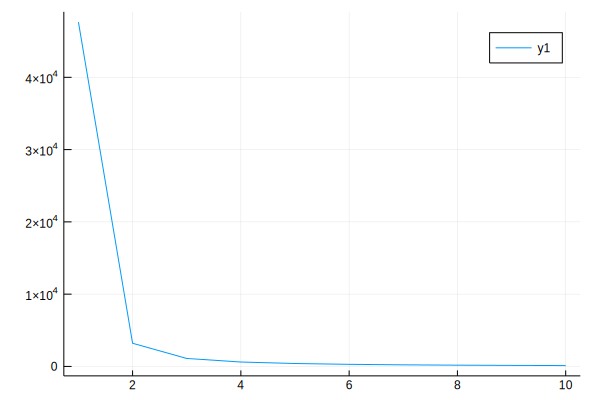

In [184]:
costs = []
@time Pres, Qres = als(tbl, 100;
    nepochs=10,
    cb=(epoch, cost)->begin
        IJulia.clear_output(true)
        println("epoch: $(epoch), cost: $(cost)")
        push!(costs, cost)
        end)

plot(costs)

### TODO: Create fit! for Unique

In [ ]:
reduce((a,b)->unique([a...,b]), tbl, select=(:movieId, :userId))

In [168]:
mstat, ustat, rstat = reduce(Group(Extrema(Int64), Extrema(Int64), Mean()), tbl, select=(:movieId, :userId, :rating)).stats
μ = value(rstat)
ni, nu = last(value(mstat)), last(value(ustat))
k = 10
λ = 0.001
rated_movies = unique(sort(collect(columns(tbl, :movieId))))
rating_users = unique(sort(collect(columns(tbl, :userId))))
pinit = rand(Normal(0, 1e-4), length(rated_movies), k)
qinit = rand(Normal(0, 1e-4), length(rating_users), k)
#P = table(rated_movies, zeros(Float64, length(rated_movies)), (pinit[:,i] for i=1:k)...,
#    names=[:movieId, :bias, (Symbol("f_",i) for i=1:k)...], pkey=:movieId)
P = ndsparse((movieId=rated_movies,), (bias=zeros(Float64, length(rated_movies)), (Symbol("f_",i)=>pinit[:,i] for i=1:k)...))
#Q = table(rating_users, zeros(Float64, length(rating_users)), (qinit[:,i] for i=1:k)...,
#    names=[:userId, :bias, (Symbol("f_",i) for i=1:k)...], pkey=:userId)
Q = ndsparse((userId=rating_users,), (bias=zeros(Float64, length(rating_users)), (Symbol("f_",i)=>qinit[:,i] for i=1:k)...))
#t_mu = map(v->(rating=v.rating - μ,), tbl)

1-d NDSparse with 610 values (11 field named tuples):
    Dimensions#  colname  type
─────────────────
1  userId   Int64
    Values#   colname  type
────────────────────
2   bias     Float64
3   f_1      Float64
4   f_2      Float64
5   f_3      Float64
6   f_4      Float64
7   f_5      Float64
8   f_6      Float64
9   f_7      Float64
10  f_8      Float64
11  f_9      Float64
12  f_10     Float64

In [169]:
P[1]

(bias = 0.0, f_1 = 4.2689931353372975e-5, f_2 = 1.6935738885898e-5, f_3 = 0.00014343336686687016, f_4 = -5.2075473032584774e-5, f_5 = -7.257363264500351e-6, f_6 = 2.360150099701945e-5, f_7 = -5.504001284613426e-5, f_8 = -1.462599926525299e-5, f_9 = 1.4297423351260456e-5, f_10 = 0.0001268587661015752)

In [172]:
Pjoin = join(P, collect(tbl[:,1]), how=:inner, lkey=:movieId, rkey=:movieId)
Pbiased = setcol(table(Pjoin), :rating, All(:bias, :rating)=>r->r.rating - μ - r.bias)
#map(r->(rating=begin r.rating - μ - r.bias end,), Pjoin)

Table with 232 rows, 13 columns:
Columns:
#   colname  type
────────────────────
1   movieId  Int64
2   bias     Float64
3   f_1      Float64
4   f_2      Float64
5   f_3      Float64
6   f_4      Float64
7   f_5      Float64
8   f_6      Float64
9   f_7      Float64
10  f_8      Float64
11  f_9      Float64
12  f_10     Float64
13  rating   Float64

In [157]:
table(Pjoin)

Table with 232 rows, 13 columns:
Columns:
#   colname  type
────────────────────
1   movieId  Int64
2   bias     Float64
3   f_1      Float64
4   f_2      Float64
5   f_3      Float64
6   f_4      Float64
7   f_5      Float64
8   f_6      Float64
9   f_7      Float64
10  f_8      Float64
11  f_9      Float64
12  f_10     Float64
13  rating   Float64

In [151]:
pushcol(t, :x, 1:5)

MethodError: MethodError: no method matching getindex(::ColDict{NDSparse{NamedTuple{(:a, :b),Tuple{Float64,Float64}},Tuple{Int64},Columns{Tuple{Int64},Tuple{Array{Int64,1}}},Columns{NamedTuple{(:a, :b),Tuple{Float64,Float64}},NamedTuple{(:a, :b),Tuple{Array{Float64,1},Array{Float64,1}}}}}})
Closest candidates are:
  getindex(::ColDict, !Matched::AbstractArray) at /Users/guillaume/.julia/packages/IndexedTables/Jw0SP/src/columns.jl:825
  getindex(::ColDict, !Matched::Any) at /Users/guillaume/.julia/packages/IndexedTables/Jw0SP/src/columns.jl:824

In [138]:
table(values(join(P, collect(tbl[:,1]), how=:inner, lkey=:movieId, rkey=:movieId)))

Table with 232 rows, 12 columns:
Columns:
#   colname  type
────────────────────
1   bias     Float64
2   f_1      Float64
3   f_2      Float64
4   f_3      Float64
5   f_4      Float64
6   f_5      Float64
7   f_6      Float64
8   f_7      Float64
9   f_8      Float64
10  f_9      Float64
11  f_10     Float64
12  rating   Float64

In [148]:
t = ndsparse(1:5, (a=randn(5), b=randn(5)))

1-d NDSparse with 5 values (2 field named tuples):
1 │ a          b
──┼─────────────────────
1 │ -0.416712  -1.32935
2 │ 0.880771   0.757857
3 │ 0.0275525  -0.281738
4 │ 0.0599767  0.412642
5 │ 0.260158   1.0212

In [125]:
map(r->(foo=r.a^2, bar=r.b^2), t)

1-d NDSparse with 5 values (2 field named tuples):
1 │ foo       bar
──┼────────────────────
1 │ 2.07341   0.0506998
2 │ 0.558361  0.717941
3 │ 3.60815   0.157246
4 │ 0.110397  0.580803
5 │ 0.345117  4.75836